In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from utilities import image_preprocess


from solvers import of_cg, of_vc, run_pcg
from image_gen import generate_test_image

from plotters import plot_flow_field, plot_performance, init_results, run_all_methods, run_vc_param_grid,plot_vc_param_comparison, filter_records


## TMA4205 - Estimation of Optical Flow
##### Julie Rose Godal og Tor Løvold Haugen
----

### Midlertidig innledning
Optical flow describes the apparent motion of image intensity over time and is used to estimate how points in an image move between two consecutive frames. In this project, the problem is modeled using the Horn–Schunck method, which assumes that the intensity of a point remains constant as it moves. This leads to a linear system of partial differential equations that can be solved numerically after discretization. The work focuses on formulating this system, analyzing its properties, and implementing different numerical approaches to compute the solution, including the Conjugate Gradient (CG) method, Gauss–Seidel smoothing, and a multigrid V–cycle.


### Theory
The optical flow field $(u,v)$ between two consecutive grayscale frames $I_0$ and $I_1$ is modeled using the Horn–Schunck method. Assuming brightness constancy together with quadratic smoothness, leads to the energy functional
$$
E(u,v) = \int \big( (I_x u + I_y v + I_t)^2 + \lambda (\|\nabla u\|^2 + \|\nabla v\|^2) \big)\, dx\, dy,
$$
where $\lambda > 0$ controls the balance between data quality and smoothness. Minimizing this energy yields the coupled Euler–Lagrange equations
$$
(I_x^2)u + (I_x I_y)v - \lambda \Delta u = -I_x I_t, \qquad
(I_x I_y)u + (I_y^2)v - \lambda \Delta v = -I_y I_t,
$$
subject to Dirichlet boundary conditions $u = v = 0$ on the image boundary.

In the discrete setting, the image domain is represented on an $m \times n$ grid with unit spacing. The temporal derivative is given by $I_t = I_1 - I_0$, while the spatial derivatives $I_x$ and $I_y$ are computed using forward finite differences and averaged across the two frames.


We examine the linear system obtained after discretizing the Horn–Schunck optical flow equations. Understanding its general structure, coupling, and boundary behavior is essential before choosing suitable numerical methods. We will then discuss how these characteristics influence the stability and solvability of the numerical problem.

The discrete system of equations for each pixel $(i,j)$ can be written as

$$
\partial_x I_{ij}^2\, u_{ij} 
+ \partial_x I_{ij}\, \partial_y I_{ij}\, v_{ij}
- \lambda (A_h^0 u)_{ij}
= - (\partial_t I)_{ij} (\partial_x I)_{ij},
$$

$$
\partial_y I_{ij}^2\, v_{ij}
+ \partial_y I_{ij}\, \partial_x I_{ij}\, u_{ij}
- \lambda (A_h^0 v)_{ij}
= - (\partial_t I)_{ij} (\partial_y I)_{ij}.
$$

These equations represent two coupled linear relations between the horizontal and vertical flow components, where the terms involving spatial derivatives of the image couple $u$ and $v$, and the Laplacian term enforces smoothness through the regularization parameter $\lambda$.

We define the spatial and temporal derivatives for simplicity as

$$
I_x := \partial_x I, \qquad
I_y := \partial_y I, \qquad
I_t := \partial_t I.
$$

Substituting these into the equations gives the form

$$
I_x^2 u + I_x I_y v - \lambda A_h^0 u = - I_t I_x,
$$

$$
I_y^2 v + I_x I_y u - \lambda A_h^0 v = - I_t I_y.
$$

Here, $A_h^0$ denotes the discrete Laplacian operator acting on the interior of the image domain.

To express this system in matrix form, we introduce diagonal matrices containing the image-dependent coefficients:

$$
D_{xx} = \mathrm{diag}(I_x^2), \qquad
D_{yy} = \mathrm{diag}(I_y^2), \qquad
D_{xy} = \mathrm{diag}(I_x I_y).
$$

This yields the full coupled system

$$
\begin{bmatrix}
D_{xx} - \lambda A_h^0 & D_{xy} \\
D_{xy} & D_{yy} - \lambda A_h^0
\end{bmatrix}
\begin{bmatrix}
U \\[2pt] V
\end{bmatrix}
=
\begin{bmatrix}
D_{xt} \\[2pt] D_{yt}
\end{bmatrix}.
$$

The structure of this matrix shows that the system couples $u$ and $v$ symmetrically through the off-diagonal blocks $D_{xy}$, while the diagonal blocks contain both the image gradient terms and the regularization operator. Thus, the coefficient matrix $A$ is symmetric and, for $\lambda > 0$, positive definite on the interior domain.

To analyze the definiteness of the system matrix, we split it into two parts. A diagonal part that depends on the image derivatives, and a Laplacian part that represents the regularization. This shows how each term contributes to the overall stability of the system.

We write the matrix as

$$
A =
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}
-
\begin{bmatrix}
\lambda A_h^0 & 0 \\
0 & \lambda A_h^0
\end{bmatrix}.
$$

The second term contains the discrete Laplacian $A_h^0$ with Dirichlet boundary conditions. It is known that the negative Laplacian under these conditions is symmetric positive definite (SPD), meaning that it contributes positively to the energy and stabilizes the system through smoothing.

Next, we analyze the diagonal part $D$, which depends on the image gradients. Let $x_1, x_2 \in \mathbb{R}$ represent arbitrary scalar coefficients, then

$$
x^T D x
=
\begin{bmatrix} x_1 & x_2 \end{bmatrix}
\begin{bmatrix}
D_{xx} & D_{xy} \\
D_{xy} & D_{yy}
\end{bmatrix}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
=
x_1^2 D_{xx} + 2x_1 x_2 D_{xy} + x_2^2 D_{yy}.
$$

This expression represents the local quadratic form associated with the data term at each pixel. Since the matrices $D_{xx}$, $D_{yy}$, and $D_{xy}$ are diagonal, the computation can be written element-wise as

$$
x^T D x = \sum_i (x_1 I_{x,i} + x_2 I_{y,i})^2 > 0.
$$

Each term in the sum is nonnegative and only vanishes if both $I_{x,i}$ and $I_{y,i}$ are zero simultaneously. Therefore, $D$ must be at least symmetric semi-positive definite.

Since the Laplacian part is SPD and the diagonal part is semi-positive definite, their sum must be SPD for $\lambda > 0$. This means that the full system matrix $A$ is symmetric positive definite, ensuring that the optical flow equations admit a unique and stable solution.

To investigate the diagonal dominance of the system matrix, we analyze the relative size of the diagonal and off-diagonal elements in each block. 

We start by writing the matrix as

$$
A =
\begin{bmatrix}
D_{xx} - \lambda A_h^0 & D_{xy} \\
D_{xy} & D_{yy} - \lambda A_h^0
\end{bmatrix}.
$$

Here, $D_{xx}$ and $D_{yy}$ are diagonal matrices containing image-gradient terms, while $A_h^0$ is the discrete Laplacian. The Laplacian contributes positive diagonal entries $d_i > 0$ and negative off-diagonal entries $-1$ corresponding to neighboring pixels.

For the $u$-component, the diagonal entry at pixel $i$ is

$$
a_{ii} = I_x[i]^2 + \lambda d_i,
$$

while the off-diagonal entries come from the Laplacian and the coupling to $v$. Neighboring pixels: $a_{ij} = -\lambda$ for $j \in \mathcal{N}(i)$. Cross-block coupling: $a_{i, N+i} = I_x[i] I_y[i]$

Diagonal dominance requires that the magnitude of the diagonal entry is greater than or equal to the sum of the magnitudes of the off-diagonal entries:

$$
|a_{ii}| \ge \sum_{j\neq i} |a_{ij}|.
$$

Substituting the expressions gives

$$
I_x[i]^2 + \lambda d_i \ge \lambda d_i + |I_x[i] I_y[i]|.
$$

After canceling the regularization terms, this simplifies to

$$
I_x[i]^2 \ge |I_x[i] I_y[i]|.
$$

Applying the same reasoning to the $v$-component gives

$$
I_y[i]^2 \ge |I_x[i] I_y[i]|.
$$

The conditions for diagonal dominance in both blocks are therefore

$$
|I_x[i]| \ge |I_y[i]|, \qquad |I_y[i]| \ge |I_x[i]|.
$$

These two inequalities can only hold simultaneously if

$$
|I_x[i]| = |I_y[i]|.
$$

This means that strict diagonal dominance occurs only in special cases where the horizontal and vertical image gradients have equal magnitude at every pixel. Hence global diagonal dominance of \(A\) cannot be guaranteed.

In summary, the discretized optical flow system forms a large, sparse, symmetric linear system whose properties are determined by the local image derivatives and the chosen regularization.By separating the operator into a data-dependent diagonal part and a regularization-based Laplacian part, we see that both components combined are SPD. Consequently, the full system matrix $A$ is symmetric positive definite. While the diagonal and Laplacian contributions stabilize the system, the presence of cross-coupling terms $I_x I_y$ prevents strict diagonal dominance in most cases. 

The lack of global diagonal dominance implies that the Jacobi and Gauss–Seidel methods are not guaranteed to converge for this system, since their convergence typically relies on the diagonal elements dominating the off-diagonal ones. This is because the convergence of these methods rely on the spectral radius of their itereation matrix. And they only converge if the spectral radius, $\rho$, is less than one, which can only be guaranteed by strict diagonal dominence. In practice, these methods may still work for some images but can converge slowly or even diverge depending on the local image gradients and coupling strength.

In contrast, the Conjugate Gradient (CG) method only requires the coefficient matrix to be symmetric positive definite, which we have shown to hold for this system. Therefore, CG is both theoretically guaranteed to converge and generally much more efficient for solving the discretized Horn–Schunck equations.

#### Implementation of Numerical Methods
From the previous section, it is known that this system operator is symmetric and positive definite, but not globally diagonally dominant. Therefore, the linear system $A(u,v)=b$ is most efficiently solved with the Conjugate Gradient (CG) method. 

The CG method iteratively minimizes the quadratic energy associated with the system matrix by updating the solution along mutually conjugate search directions. In each iteration, a step length is computed to minimize the residual in the current direction, and a new search direction is formed as a combination of the current residual and the previous direction. This ensures that convergence occurs in at most as many steps as the number of unknowns.

When implementing this method, a five-point Laplacian is applied only on the strict interior. All inner products and updates are restricted to interior indices, while the border remains clamped to zero. Thus, boundary pixels are excluded from all linear algebra and kept at zero, which enforces the dirichlet condition.

Convergence is declared when the relative residual
$$
\frac{\|r_k\|_2}{\|r_0\|_2} < \texttt{tol}, \qquad
\|r_k\|_2^2 = \langle r_u,r_u\rangle + \langle r_v,r_v\rangle,
$$
drops below the prescribed tolerance. This applies to all future implementations as well.


#### Task 3 — Multigrid V–Cycle for Optical Flow

To improve the efficiency of solving the Horn–Schunck optical flow equations, a **multigrid V–cycle** is used. The discrete system solved on the interior can be written as
$$
A(u, v) = [ [Ix², IxIy], [IxIy, Iy²] ] [u, v]^T - λ[Δu, Δv]^T = [-IxIt, -IyIt]^T,
$$
where λ is the regularization parameter and u = v = 0 on the boundary. The multigrid approach combines local smoothing and coarse-grid correction to remove errors at all spatial frequencies more efficiently than a single grid method.

The smoother applies a red–black Gauss–Seidel iteration that updates interior pixels alternately by solving a small coupled 2×2 system for each pixel. This reduces high-frequency errors in both u and v while keeping the boundary fixed at zero. After a few pre-smoothing sweeps, the residual r = b − A(u, v) is computed and transferred to a coarser grid using restriction. Restriction is done with full-weighting, averaging neighboring values with weights [1/4, 1/2, 1/4] in both directions. The image derivatives Ix and Iy are restricted in the same way to preserve the structure of the operator.

On the coarse grid, the error equation is solved approximately, either by recursion to the next coarser level or, at the coarsest grid, by a small number of Conjugate Gradient iterations. The resulting coarse-grid error is interpolated back to the fine grid through prolongation using bilinear interpolation, and the fine-grid solution is corrected by adding this interpolated error. A few post-smoothing sweeps are then applied to remove the remaining high-frequency errors.

Each V–cycle therefore performs pre-smoothing, residual computation, restriction, coarse solve, prolongation, and post-smoothing. This hierarchy of grids efficiently removes both low- and high-frequency components of the error, producing grid-independent convergence for the coupled optical flow equations while maintaining Dirichlet boundaries and the coupling between u and v through the image derivatives.





### V_cyle as a preconditioner for Conjugate gradient: 

For CG the preconditioner has to be linear and SPD: 
### Linearity:
The V_cycle can be considered linear, as the smoothing is linear(using Gaus-Seidel on a SPD linear system). The smoothing will be further discussed for SPD.
The restriction and prolongation has to be linear. 
The coarse solver (in our case CG) has to be linear. This is assumed as we use CG in the small linear SPD system in the coarse step ### mer teori til akkurat dette??

As the conjugate gradient method requieres a SPD matrix A to be guaranteed convergence, the preconditioner needs to keep these properties for A. In in out code this is implemented as the presmoother beeing RB ordered and the postsmoother beeing BS ordered. 
In the following we prove that applying RB-BR preserves SPD-properties. For this to be correct, the number of sweeps also have to be the same for the presmoothing and postsmoothing(s1=s2).


For the intergrid transfer operators we use standard bilinear
interpolation for prolongation and full-weighting for restriction.
On the fine grid, the prolongation operator P is defined by
injecting coarse values at every second grid point and using linear
interpolation along edges and bilinear interpolation in the cell
centres. The restriction operator R uses the classical 3×3
full-weighting stencil

$$
\frac{1}{16}
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{bmatrix}
$$

around each coarse-grid point. In 1D, it is well known that
full-weighting restriction and linear interpolation satisfy
$R = \tfrac{1}{2} P^\top$; in 2D, the operators are tensor products
of the 1D ones, so we obtain $R = \tfrac{1}{4} P^\top$.
Thus, up to a constant factor, the restriction is the adjoint of the
prolongation. With the Galerkin definition of the coarse-grid operator,
$
A_{2h} = R A_h P,
$
this choice guarantees that $A_{2h}$ remains symmetric whenever $A_h$
is symmetric. Together with the symmetric RB–BR Gauss–Seidel smoother,
this ensures that the resulting V-cycle defines a symmetric,
positive definite preconditioner suitable for use with CG.#ref boken her#
Thus the Restriction and prolongation is linear and preserves the symmetry of the problem. 




# Lemma (RB→BR keeps SPD)

Let $A \in \mathbb{R}^{n \times n}$ be **symmetric positive definite (SPD)** and let a red–black
coloring of the grid induce a permutation of the unknowns that puts all red nodes
first and all black nodes second. Denote this permutation by an orthogonal
(permutation) matrix $\Pi$ and the permuted matrix by
$$
\tilde A = \Pi^\top A \Pi.
$$
Then $\tilde A$ is SPD. We split
$$
\tilde A = D + L + L^\top,
$$
where $D$ is block diagonal in this ordering and $L$ is strictly
lower triangular.

Consider one red–black forward Gauss–Seidel sweep followed by one
black–red backward Gauss–Seidel sweep on $\tilde A$. The combined update
has the form
$$
x^{(2)} = x^{(0)} + \tilde B_{\mathrm{SGS}}\,(b-\tilde A x^{(0)}),
\qquad
\tilde B_{\mathrm{SGS}} = (D+L^\top)^{-1} D (D+L)^{-1}.
$$
Then $\tilde B_{\mathrm{SGS}}$ is **SPD**. Therefore, the corresponding operator in the
original ordering,
$$
B_{\mathrm{SGS}} = \Pi\,\tilde B_{\mathrm{SGS}}\,\Pi^\top,
$$
is also SPD. Therefore, RB presmoothing followed by BR postsmoothing preserves SPD.

## Proof

### 1: Red-Black and Black-Red ordering
We want to show that applying first Red-Black and then Black-Red yealds the Symmetric Gaus-Seidel method
Let $r^{(0)} := b - \tilde A x^{(0)}$.

A **forward Gauss–Seidel sweep** (RB in this ordering) is
$$
x^{(1)} = x^{(0)} + (D+L)^{-1} r^{(0)}.
$$

And 
$$
r^{(1)} = -\,L^\top (D+L)^{-1} r^{(0)}.
$$

A **backward Gauss–Seidel sweep** (BR):
$$
x^{(2)} = x^{(1)} + (D+L^\top)^{-1} r^{(1)}.
$$

Substitute $r^{(1)}$:
$$
x^{(2)} = x^{(1)} - (D+L^\top)^{-1} L^\top (D+L)^{-1} r^{(0)}.
$$

Using $r^{(0)} = b - \tilde A x^{(0)}$, this can be written as
$$
x^{(2)} = x^{(0)} + \tilde B_{\mathrm{SGS}} (b - \tilde A x^{(0)}),
$$
with
$$
\tilde B_{\mathrm{SGS}} := (D+L)^{-1} - (D+L^\top)^{-1} L^\top (D+L)^{-1}.
$$

Now we simplify $\tilde B_{\mathrm{SGS}}$.

Note that
$$
D = (D+L^\top) - L^\top.
$$

Then
$$
\begin{aligned}
(D+L^\top)^{-1} D (D+L)^{-1}
&= (D+L^\top)^{-1} \bigl[(D+L^\top) - L^\top\bigr] (D+L)^{-1} \\
&= (D+L^\top)^{-1} (D+L^\top) (D+L)^{-1}
   - (D+L^\top)^{-1} L^\top (D+L)^{-1} \\
&= (D+L)^{-1} - (D+L^\top)^{-1} L^\top (D+L)^{-1}.
\end{aligned}
$$

Thus
$$
\tilde B_{\mathrm{SGS}} = (D+L^\top)^{-1} D (D+L)^{-1}.
$$

So the **RB→BR combination** in the permuted ordering is exactly the
symmetric Gauss–Seidel operator $\tilde B_{\mathrm{SGS}}$.



### Show $\tilde B_{\mathrm{SGS}}$ is SPD

Consider its inverse:
$$
\tilde B_{\mathrm{SGS}}^{-1}
= (D+L) D^{-1} (D+L^\top).
$$

Let $D^{1/2}$ denote the SPD square root of $D$ and define
$$
K := D^{-1/2} L D^{-1/2}.
$$

Then
$$
\begin{aligned}
\tilde B_{\mathrm{SGS}}^{-1}
&= D^{1/2} \bigl(I + D^{-1/2} L D^{-1/2}\bigr)
          \bigl(I + D^{-1/2} L^\top D^{-1/2}\bigr) D^{1/2} \\
&= D^{1/2} (I + K)(I + K^\top) D^{1/2}.
\end{aligned}
$$

For any nonzero vector $x$,
$$
\begin{aligned}
x^\top \tilde B_{\mathrm{SGS}}^{-1} x
&= x^\top D^{1/2} (I + K)(I + K^\top) D^{1/2} x \\
&= y^\top (I + K)(I + K^\top) y,
\quad \text{where } y := D^{1/2} x, \\
&= \bigl((I + K^\top) y\bigr)^\top \bigl((I + K^\top) y\bigr) \\
&= \|(I + K^\top) y\|_2^2.
\end{aligned}
$$

Since $D^{1/2}$ is invertible and $I + K^\top$ is unit upper triangular
and therefore invertible, we have $x \neq 0 \Rightarrow y \neq 0 \Rightarrow (I+K^\top)y \neq 0$.
Hence
$$
x^\top \tilde B_{\mathrm{SGS}}^{-1} x > 0 \quad \text{for all } x \neq 0.
$$

Thus $\tilde B_{\mathrm{SGS}}^{-1}$ is SPD, and therefore $\tilde B_{\mathrm{SGS}}$
is also SPD.


### 3. Undo the permutation

In the original variable ordering (before red–black permutation),
the preconditioner is
$$
B_{\mathrm{SGS}} := \Pi \tilde B_{\mathrm{SGS}} \Pi^\top.
$$

For any nonzero $y$,
$$
\begin{aligned}
y^\top B_{\mathrm{SGS}} y
&= y^\top \Pi \tilde B_{\mathrm{SGS}} \Pi^\top y \\
&= (\Pi^\top y)^\top \tilde B_{\mathrm{SGS}} (\Pi^\top y).
\end{aligned}
$$

Since $\Pi$ is orthogonal and $\tilde B_{\mathrm{SGS}}$ is SPD,
this is strictly positive for all $y \neq 0$. Hence $B_{\mathrm{SGS}}$ is SPD
in the original ordering.


**Conclusion.** One red–black forward Gauss–Seidel sweep followed by one
black–red backward Gauss–Seidel sweep is exactly the symmetric Gauss–Seidel
operator (up to permutation), which is SPD. Therefore, **RB pre + BR post
keeps the SPD property.


oppgave 4

#### Numerical tests
In order to evaluate the methods implemented in the previous section, numerical experiments will be preformed on each method. These tests will use the second testcase implemented in generate_test_images using the supplemented code from the course. This function produces $(N \times N)$ images of two Gaussians circling each other. The methods will be compared when solving images of size $2^k \times 2^k$ for $k = 6,\dots,9$. The regularisation parameter will be given by $\lambda^k = 4^{k−4}$, where $k$ depends on the image size, for these tests.

##### Temp skrevet bare så jeg ikke glemmer det
Additionally, we will test the different methods using the images frame10.png and frame11.png from the webpage of the course.

In [ ]:

tol = 1e-8
maxit = 2000

methods = ["cg", "vc", "pcg"]
Ns = [2**i for i in range(6, 11)]  # [64, 128, ..., 1024]
###make a dictionary to store results
results = {
    "cg":  {
        "N": np.array(Ns, dtype=int),
        "iterations": np.zeros(len(Ns)),
        "time": np.zeros(len(Ns)),
        "residual_history": [[] for _ in Ns],
    },
    "vc":  {
        "N": np.array(Ns, dtype=int),
        "iterations": np.zeros(len(Ns)),
        "time": np.zeros(len(Ns)),
        "residual_history": [[] for _ in Ns],
    },
    "pcg": {
        "N": np.array(Ns, dtype=int),
        "iterations": np.zeros(len(Ns)),
        "time": np.zeros(len(Ns)),
        "residual_history": [[] for _ in Ns],
    },
}

###loop through different image sizes and run solvers 
for k, N in enumerate(Ns):
    lam = 4**(int(np.log2(N)) - 4)

    Im_0, Im_1 = generate_test_image(N, testcase=2)
    u0, v0, Ix, Iy, rhsu, rhsv, I0, I1 = image_preprocess(Im_0, Im_1)

    # CG 
    start_time = time.time()
    u_cg, v_cg, it_cg, rel_cg, res_cg = of_cg(u0, v0, Ix, Iy, lam, rhsu, rhsv, tol=tol, maxit=maxit)
    t_cg = time.time() - start_time

    results["cg"]["iterations"][k] = it_cg
    results["cg"]["time"][k] = t_cg
    results["cg"]["residual_history"][k] = res_cg

    #V-cycle 
    start_time = time.time()
    u_vc, v_vc, it_vc, rel_vc, res_vc = of_vc(u0, v0, Ix, Iy, lam, rhsu, rhsv, tol=tol, maxit=maxit)
    t_vc = time.time() - start_time

    results["vc"]["iterations"][k] = it_vc
    results["vc"]["time"][k] = t_vc
    results["vc"]["residual_history"][k] = res_vc

    #PCG
    start_time = time.time()
    u_pcg, v_pcg, it_pcg, rel_pcg, res_pcg = run_pcg(u0, v0, Ix, Iy, lam, rhsu, rhsv, tol=tol, maxit=maxit)
    t_pcg = time.time() - start_time

    results["pcg"]["iterations"][k] = it_pcg
    results["pcg"]["time"][k] = t_pcg
    results["pcg"]["residual_history"][k] = res_pcg

n_f = 17, m_f = 17
n_f = 33, m_f = 33
n_f = 65, m_f = 65
r2_new: 10633.82212859016, r2_0: 1926206478.139577
V-cycle iteration 1, relative residual: 2.35e-03
n_f = 17, m_f = 17
n_f = 33, m_f = 33
n_f = 65, m_f = 65
r2_new: 727.7484923159645, r2_0: 1926206478.139577
V-cycle iteration 2, relative residual: 6.15e-04
n_f = 17, m_f = 17
n_f = 33, m_f = 33
n_f = 65, m_f = 65
r2_new: 107.0220348293091, r2_0: 1926206478.139577
V-cycle iteration 3, relative residual: 2.36e-04
n_f = 17, m_f = 17
n_f = 33, m_f = 33
n_f = 65, m_f = 65
r2_new: 16.448811910474333, r2_0: 1926206478.139577
V-cycle iteration 4, relative residual: 9.24e-05
n_f = 17, m_f = 17
n_f = 33, m_f = 33
n_f = 65, m_f = 65
r2_new: 2.7599351320275853, r2_0: 1926206478.139577
V-cycle iteration 5, relative residual: 3.79e-05
n_f = 17, m_f = 17
n_f = 33, m_f = 33
n_f = 65, m_f = 65
r2_new: 0.4484848757383457, r2_0: 1926206478.139577
V-cycle iteration 6, relative residual: 1.53e-05
n_f = 17, m_f = 17
n_f = 33, m_f = 33
n_f = 65, m_f = 6

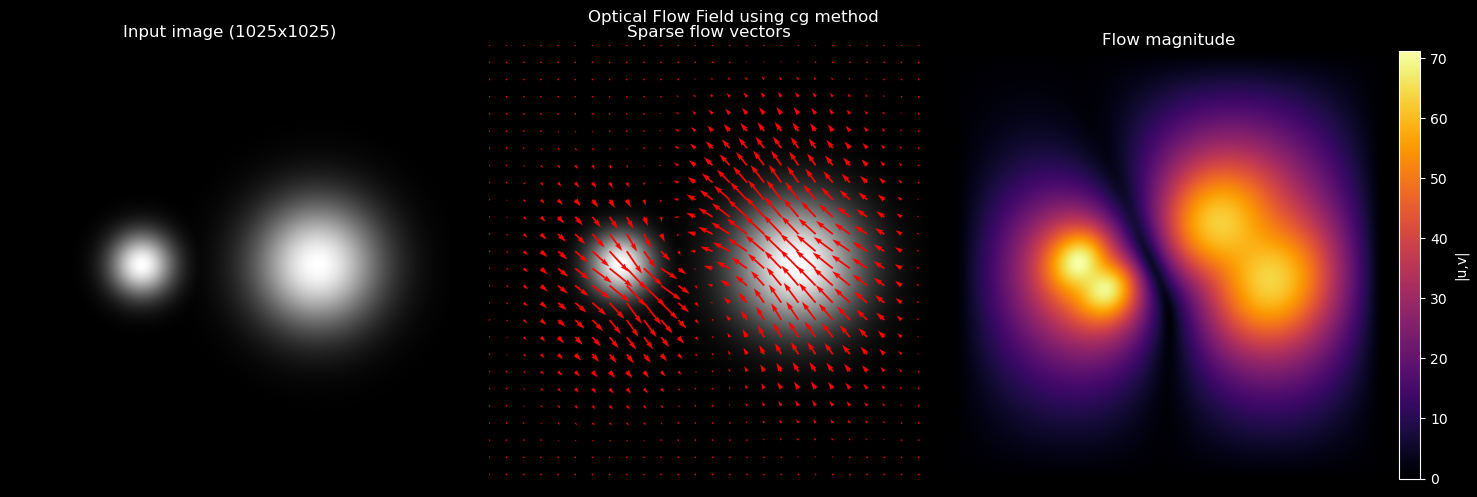

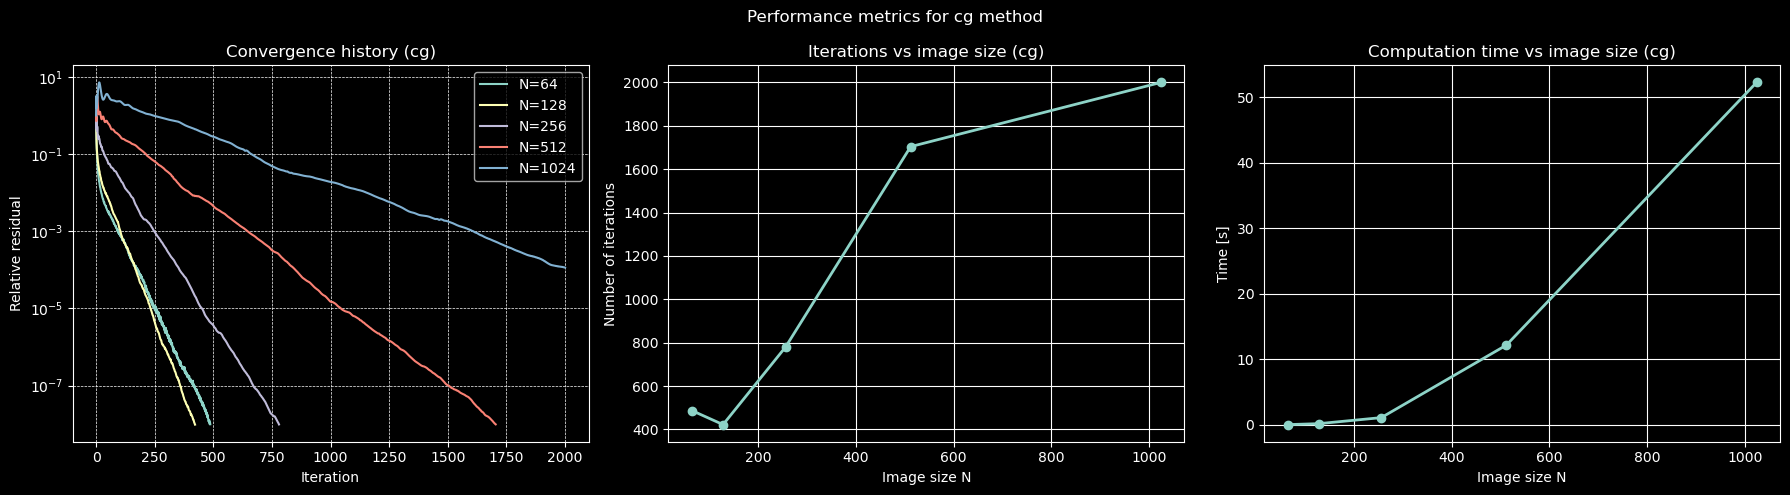

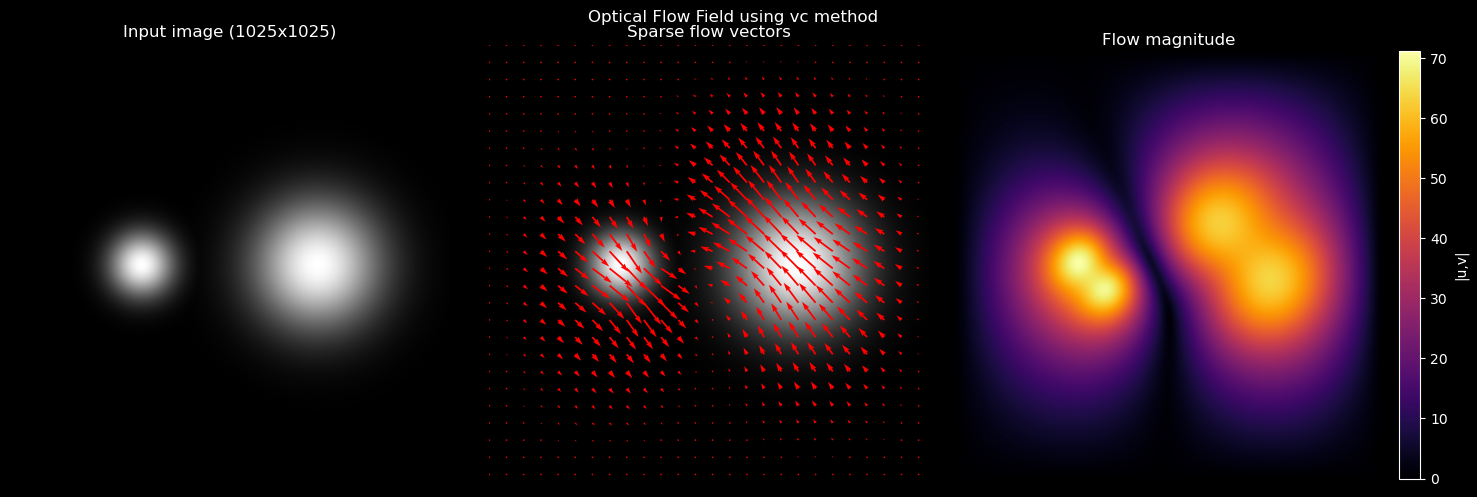

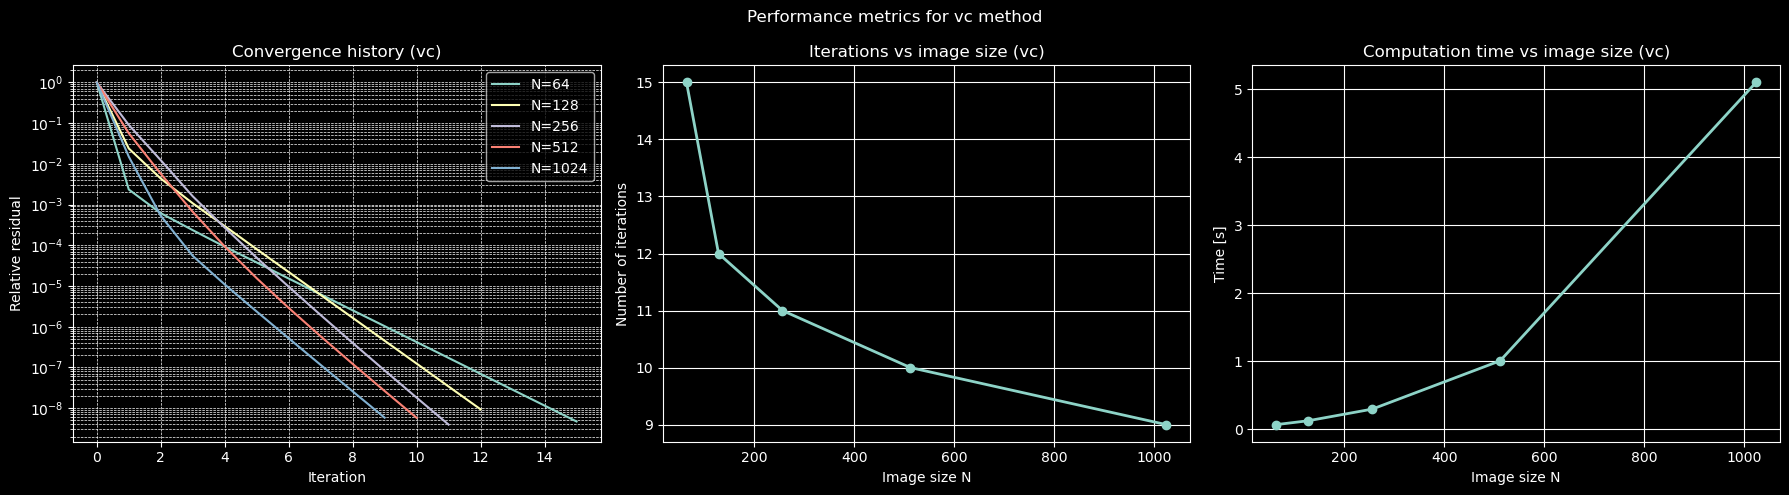

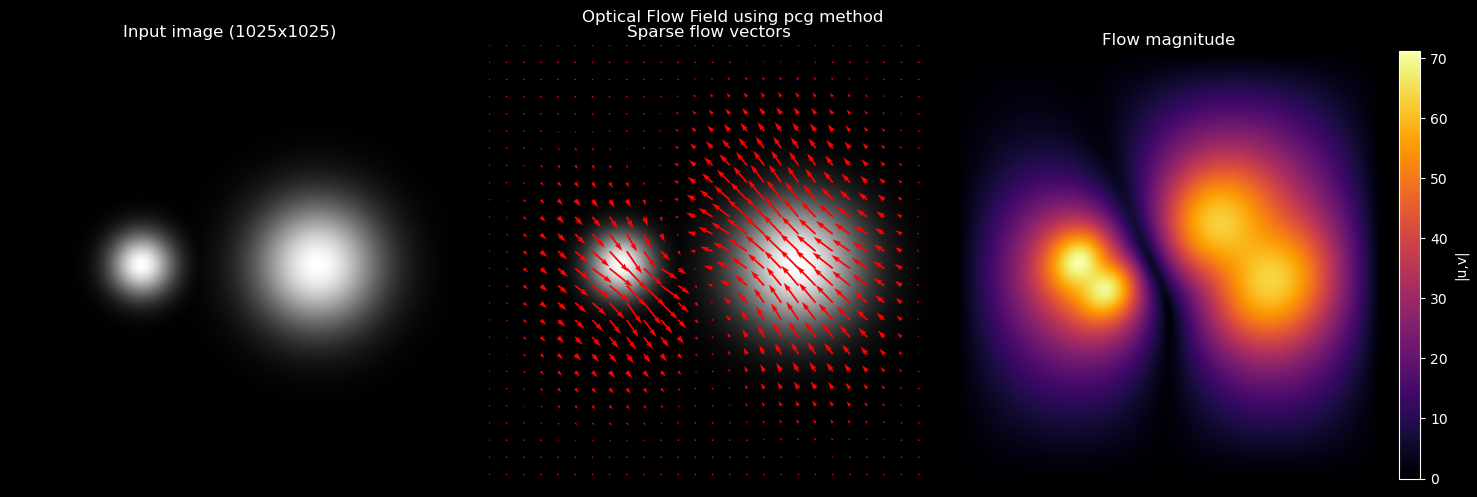

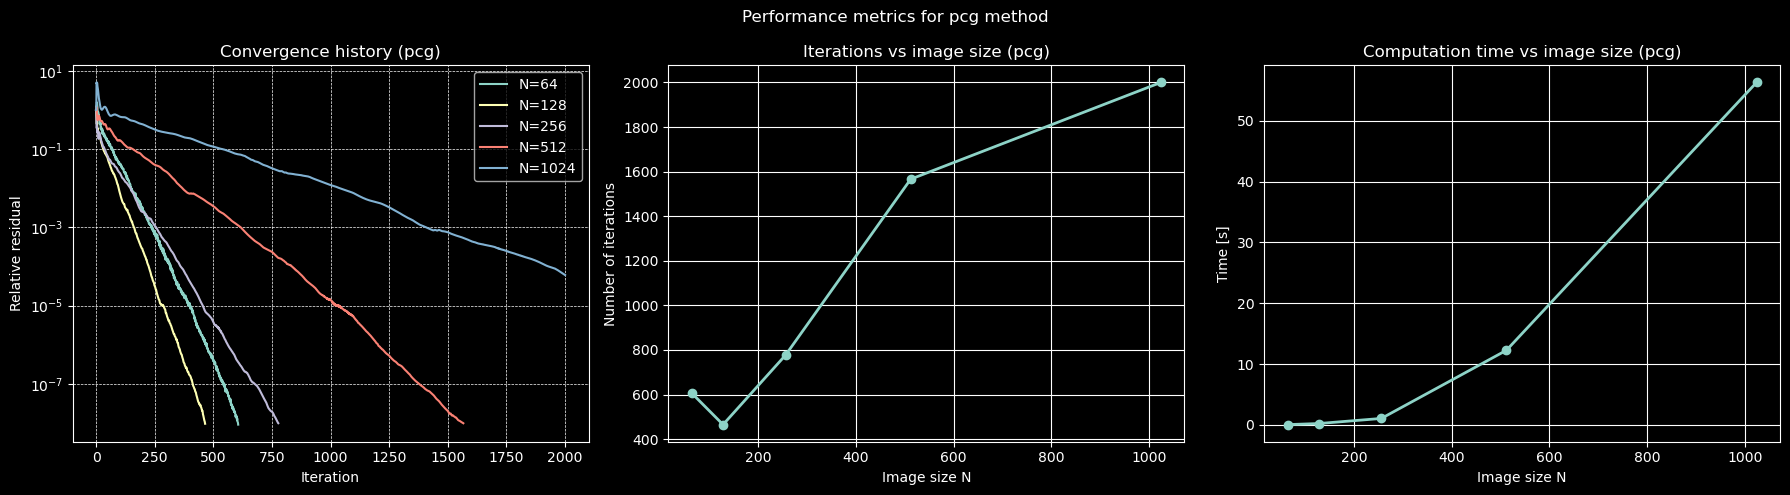

In [3]:
plot_flow_field(I0, u_cg, v_cg, method='cg')
plot_performance(results, method="cg")

plot_flow_field(I0, u_vc, v_vc, method='vc')
plot_performance(results, method="vc")

plot_flow_field(I0, u_pcg, v_pcg, method='pcg')
plot_performance(results, method="pcg")


In [9]:
N = 64

s1_list = [1, 2, 3, 4]
s2_list = [1, 2, 3, 4]      # allow asymmetric combos
level_list = [3, 4, 5]
lambda_list = [4.0,16.0,64.0]

vc_records = run_vc_param_grid(
    N=N,
    s1_list=s1_list,
    s2_list=s2_list,
    level_list=level_list,
    lambda_list=lambda_list,
    generate_test_image=generate_test_image,
    image_preprocess=image_preprocess,
    of_vc=of_vc,
    testcase=2,
    tol=1e-8,
    maxit=2000,
)




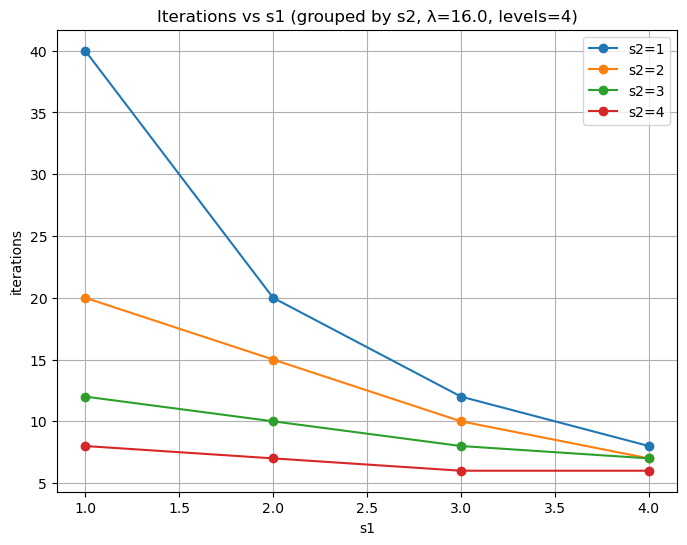

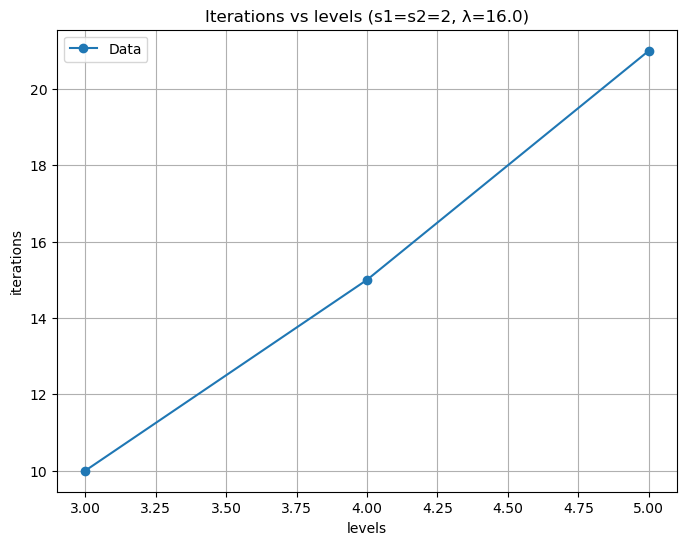

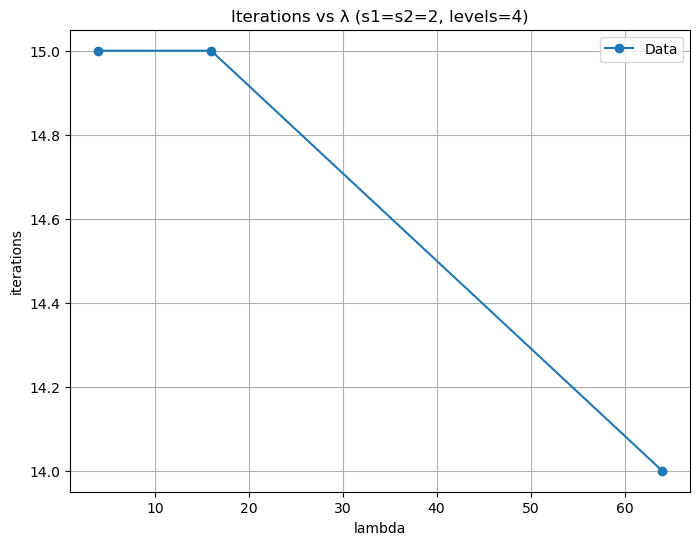

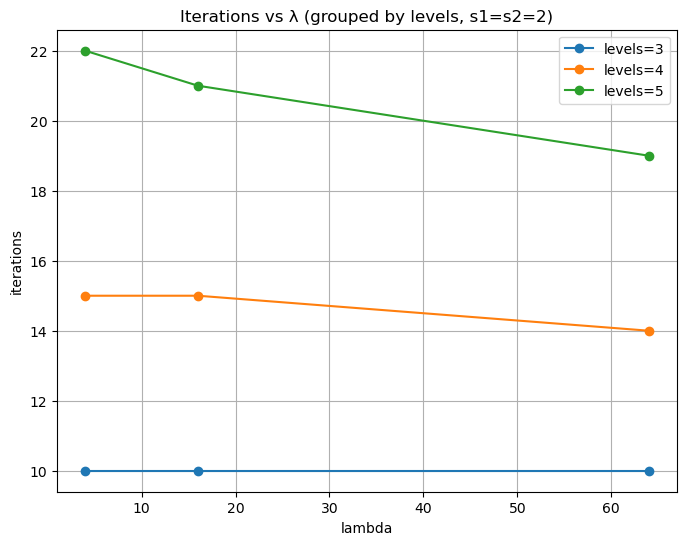

In [ ]:
plot_vc_param_comparison(
    records=vc_records,
    x_param="s1",
    y_param="iterations",
    group_by="s2",
    filters={"N": N, "lambda": 16.0, "levels": 4},
    title="Iterations vs s1 (grouped by s2, lambda=16.0, levels=4)",
)

plot_vc_param_comparison(
    records=vc_records,
    x_param="levels",
    y_param="iterations",
    group_by=None,
    filters={"N": N, "lambda": 16.0, "s1": 2, "s2": 2},
    title="Iterations vs levels (s1=s2=2, lambda=16.0)",
)

plot_vc_param_comparison(
    vc_records,
    x_param="lambda",
    y_param="iterations",
    group_by=None,
    filters={"N": N, "s1": 2, "s2": 2, "levels": 4},
    title="Iterations vs lambda (s1=s2=2, levels=4)",
)

plot_vc_param_comparison(
    vc_records,
    x_param="lambda",
    y_param="iterations",
    group_by="levels",
    filters={"N": N, "s1": 2, "s2": 2},
    title="Iterations vs lambda (grouped by levels, s1=s2=2)",
)


In [13]:
N = 256
s1_list = [1, 2, 3, 4]
s2_list = [1, 2, 3, 4]          # allows asymmetric tests if you want
level_list = [3, 4, 5]          # 3–5 V-cycle levels
lambda_base = 256.0             # from λ_k formula for N=256
lambda_list = [lambda_base / 4, lambda_base, lambda_base * 4]  # [64, 256, 1024]

vc_records = run_vc_param_grid(
    N=N,
    s1_list=s1_list,
    s2_list=s2_list,
    level_list=level_list,
    lambda_list=lambda_list,
    generate_test_image=generate_test_image,
    image_preprocess=image_preprocess,
    of_vc=of_vc,
    testcase=2,
    tol=1e-8,
    maxit=2000,
)


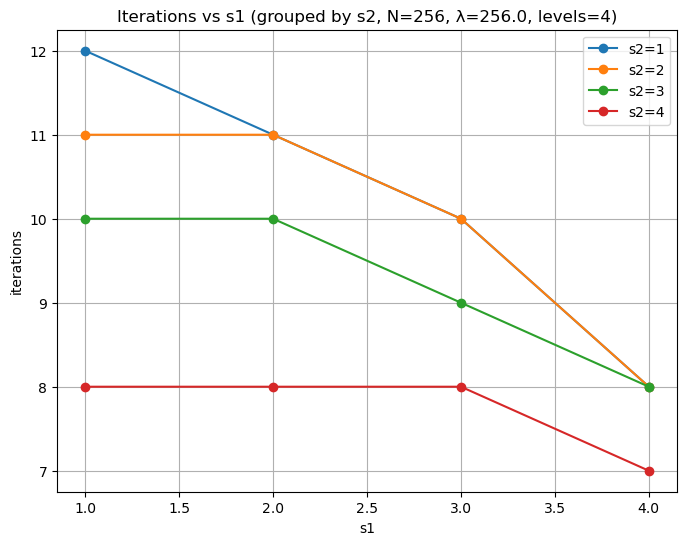

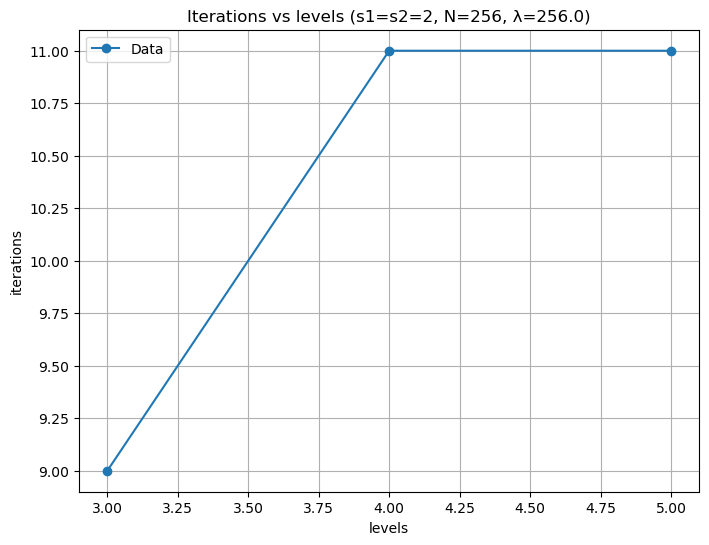

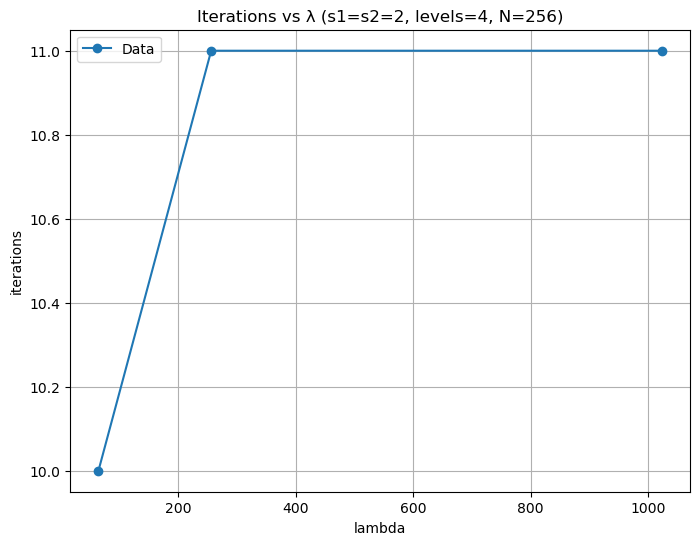

In [14]:
plot_vc_param_comparison(
    records=vc_records,
    x_param="s1",
    y_param="iterations",
    group_by="s2",
    filters={"N": N, "lambda": lambda_base, "levels": 4},
    title=f"Iterations vs s1 (grouped by s2, N={N}, λ={lambda_base}, levels=4)",
)

plot_vc_param_comparison(
    records=vc_records,
    x_param="levels",
    y_param="iterations",
    group_by=None,
    filters={"N": N, "lambda": lambda_base, "s1": 2, "s2": 2},
    title=f"Iterations vs levels (s1=s2=2, N={N}, λ={lambda_base})",
)


plot_vc_param_comparison(
    records=vc_records,
    x_param="lambda",
    y_param="iterations",
    group_by=None,
    filters={"N": N, "s1": 2, "s2": 2, "levels": 4},
    title=f"Iterations vs λ (s1=s2=2, levels=4, N={N})",
)



In [ ]:
frame0_path = "test_images/frame10.png"
frame1_path = "test_images/frame11.png"
Im_0 = plt.imread(frame0_path)
Im_1 = plt.imread(frame1_path)